Importaciones

In [1]:
import os

import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.data.experimental import AUTOTUNE

import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

Señas a Entrenar

In [5]:
CLASSES = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'Q', 'R', 'U', 'V', 'W',
    'X', 'Y', 'Z', 'nothing', 'space'  # 25 clases
]

Creacion del Modelo

In [5]:
# Base pre-entrenado (congelado inicialmente)
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = True
# Congelar todas las capas excepto las últimas 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(CLASSES), activation="softmax")
])

# Compilación
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 112 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Preparar Data

In [3]:
# Configuración inicial
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
DATA_PATH = "/content/drive/MyDrive/datos_train2"

# Cargar datasets
train_ds = image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

val_ds = image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

def preprocess(image, label):
    if image.shape[-1] != 3:
        image = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))  # Fuerza 3 canales

    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    return image, label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 8779 files belonging to 25 classes.
Using 7024 files for training.
Found 8779 files belonging to 25 classes.
Using 1755 files for validation.


Probando y analizando Data

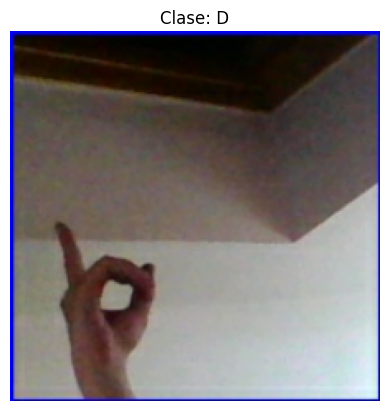

In [23]:
for images, labels in train_ds.take(1):
    img = images[0].numpy()

    img = (img + 1.0) * 127.5  # Escalar de [-1, 1] a [0, 255]
    img = img.astype("uint8")   # Convertir a formato entero

    plt.imshow(img)
    plt.title(f"Clase: {CLASSES[labels[0].numpy()]}")
    plt.axis("off")

    plt.show()

In [ ]:
for image, _ in train_ds.take(20):
    print("Valores mínimos/máximos:", image.numpy().min(), image.numpy().max())  # Debe ser ≈ -1.0 y 1.0

In [ ]:
for image, _ in train_ds.take(20):
    print("Formato de imagen:", image.shape)  # Debe ser (224, 224, 3)

Mini Entrenamiento para estudiar Parametros de Modelo

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]
model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)
mini_train = train_ds.take(1)  # 1 batch
model.fit(mini_train, epochs=20, validation_data=mini_train)

Entrenamiento del modelo

In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model_phase1.keras", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]

# Entrenar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Testeo del modelo

In [14]:
test_loss, test_acc = best_model.evaluate(val_ds)
print(f"Precisión en Test: {test_acc*100:.2f}%")  # Esperado: 93-95%

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9864 - loss: 0.0413
Precisión en Test: 98.96%


Guardar el modelo completo y guardar mejor época (Aparte)

In [ ]:
best_model = tf.keras.models.load_model("best_model_phase1.keras")

In [29]:
model.save_weights("/content/drive/MyDrive/modeloAdaptado/modelMejorado_weights.weights.h5")

In [28]:
model.save("/content/drive/MyDrive/modeloAdaptado/sign_language_modelMejorado.keras")

In [44]:
model = load_model("/content/drive/MyDrive/modeloAdaptado/sign_language_modelMejorado.keras")
test_loss, test_acc = model.evaluate(val_ds)
print(f"Precisión del mejor modelo: {test_acc*100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.9943 - loss: 0.0228
Precisión del mejor modelo: 99.54%


análisis final del modelo

In [31]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 25)                  │           6,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,971,277 (26.59 MB)

 Trainable params: 2,189,465 (8.35 MB)

 Non-trainable params: 402,880 (1.54 MB)

 Optimizer params: 4,378,932 (16.70 MB)